# Style Transfer

<img src="https://i0.wp.com/chelseatroy.com/wp-content/uploads/2018/12/neural_style_transfer.png?resize=768%2C311&ssl=1">

La idea de este trabajo final es reproducir el siguiente paper:

https://arxiv.org/pdf/1508.06576.pdf

El objetivo es transferir el estilo de una imagen dada a otra imagen distinta. 

Como hemos visto en clase, las primeras capas de una red convolucional se activan ante la presencia de ciertos patrones vinculados a detalles muy pequeños.

A medida que avanzamos en las distintas capas de una red neuronal convolucional, los filtros se van activando a medida que detectan patrones de formas cada vez mas complejos.

Lo que propone este paper es asignarle a la activación de las primeras capas de una red neuronal convolucional (por ejemplo VGG19) la definición del estilo y a la activación de las últimas capas de la red neuronal convolucional, la definición del contenido.

La idea de este paper es, a partir de dos imágenes (una que aporte el estilo y otra que aporte el contenido) analizar cómo es la activación de las primeras capas para la imagen que aporta el estilo y cómo es la activación de las últimas capas de la red convolucional para la imagen que aporta el contenido. A partir de esto se intentará sintetizar una imagen que active los filtros de las primeras capas que se activaron con la imagen que aporta el estilo y los filtros de las últimas capas que se activaron con la imagen que aporta el contenido.

A este procedimiento se lo denomina neural style transfer.

# En este trabajo se deberá leer el paper mencionado y en base a ello, entender la implementación que se muestra a continuación y contestar preguntas sobre la misma.

# Una metodología posible es hacer una lectura rápida del paper (aunque esto signifique no entender algunos detalles del mismo) y luego ir analizando el código y respondiendo las preguntas. A medida que se planteen las preguntas, volviendo a leer secciones específicas del paper terminará de entender los detalles que pudieran haber quedado pendientes.

Lo primero que haremos es cargar dos imágenes, una que aporte el estilo y otra que aporte el contenido. A tal fin utilizaremos imágenes disponibles en la web.

In [2]:
# Imagen para estilo
!wget https://upload.wikimedia.org/wikipedia/commons/5/52/La_noche_estrellada1.jpg

# Imagen para contenido
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/f/f4/Neckarfront_T%C3%BCbingen_Mai_2017.jpg/775px-Neckarfront_T%C3%BCbingen_Mai_2017.jpg

# Creamos el directorio para los archivos de salida
!mkdir content/output

--2022-06-29 16:57:22--  https://upload.wikimedia.org/wikipedia/commons/5/52/La_noche_estrellada1.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.154.240, 2620:0:861:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.154.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 223725 (218K) [image/jpeg]
Saving to: ‘La_noche_estrellada1.jpg.1’

La_noche_estrellada 100%[===================>] 218,48K   348KB/s    in 0,6s    

2022-06-29 16:57:23 (348 KB/s) - ‘La_noche_estrellada1.jpg.1’ saved [223725/223725]

--2022-06-29 16:57:23--  https://upload.wikimedia.org/wikipedia/commons/thumb/f/f4/Neckarfront_T%C3%BCbingen_Mai_2017.jpg/775px-Neckarfront_T%C3%BCbingen_Mai_2017.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.154.240, 2620:0:861:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.154.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 153015 (149K) [

In [1]:
from keras.preprocessing.image import load_img, save_img, img_to_array
import numpy as np
from scipy.optimize import fmin_l_bfgs_b
import time
import argparse

from keras.applications import vgg19
from keras import backend as K
from pathlib import Path
import base64
from IPython.display import HTML

Using TensorFlow backend.


In [2]:
# Definimos las imagenes que vamos a utilizar, y el directorio de salida
base_image_path = Path("./images/775px-Neckarfront_Tübingen_Mai_2017.jpg")
style_reference_image_path = Path("./images/La_noche_estrellada1.jpg")
result_prefix = Path("./output/")
iterations = 100

# 1) En base a lo visto en el paper ¿Qué significan los parámetros definidos en la siguiente celda?

#### Respuesta: <br /> 

Son los __pesos__ que se le asignan a los términos de la __función de costo__:  <br />
- __style_weight__ es el peso del término de __estilo__, en el paper es __$\beta$,__ mientras más grande sea $\beta$ mayor será la penalización a la diferencia con el estilo buscado.<br />  
- __content_weight__ es el peso del término del __contenido__, en el paper es __$\alpha$,__ mientras más grande sea $\alpha$ mayor será la penalización a la diferencia con el contenido. <br />
- __total_variation_weight__ en esta implementación es el peso que acompaña al tercer término de la función de costo, este esta relacionado con la variación lateral y horizontal de la imagen que se esta generando. Mientras más grande sea el  __total_variation_weight__ mayor será la penalización a los cambios laterales y horizontales en la imagen, dando una imagen más suave.
- En el paper muestran ejemplos de distintos __ratios__ $\alpha / \beta$ y se ve que hasta ratios del orden $10^{-3}$ hay un compromiso entre estilo y contenido, a partir de ratios del orden de $10^{-4}$ predomina fuertemente el estilo.

In [3]:
total_variation_weight = 0.1
style_weight = 10
content_weight = 1

In [4]:
# Definimos el tamaño de las imágenes a utilizar
width, height = load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

# 2) Explicar qué hace la siguiente celda. En especial las últimas dos líneas de la función antes del return. ¿Por qué?

Ayuda: https://keras.io/applications/

#### Respuesta: <br />
- En la primer linea se carga la imagen en formato PIL con un reshape a un tamaño (__img_nrows, img_ncols__).<br />
- En la segunda linea se pasa de formato PIL a un numpy array.<br />
- En la tercera linea se le agrega una cuarta dimensión al array en la que se va a indicar el número de elemento del batch.<br />
- En la cuarta linea se hace un preproceso necesario para la entrada a la red, en el que se cambian de orden los canales de RGB a BGR y se escalan los valores de cada canal, centrándolos alrededor de cero respecto al ImageNet dataset que fue el utilizado para entrenar la VGG19Net.

In [5]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

# 3) Habiendo comprendido lo que hace la celda anterior, explique de manera muy concisa qué hace la siguiente celda. ¿Qué relación tiene con la celda anterior?

##### Respuesta: <br />

Se puede considerar a la función __deprocess_image()__ como el preproceso inverso a __preprocess_image()__. <br />
En el que se quita una dimensión del arreglo, se lo escala 0-255 y se reordena a RGB.

In [6]:
def deprocess_image(x):
    x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [7]:
# get tensor representations of our images
# K.variable convierte un numpy array en un tensor, para 
base_image = K.variable(preprocess_image(base_image_path))
style_reference_image = K.variable(preprocess_image(style_reference_image_path))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [8]:
combination_image = K.placeholder((1, img_nrows, img_ncols, 3))

Aclaración:

La siguiente celda sirve para procesar las tres imagenes (contenido, estilo y salida) en un solo batch.

In [9]:
# combine the 3 images into a single Keras tensor
input_tensor = K.concatenate([base_image,
                              style_reference_image,
                              combination_image], axis=0)

In [10]:
# build the VGG19 network with our 3 images as input
# the model will be loaded with pre-trained ImageNet weights
model = vgg19.VGG19(input_tensor=input_tensor,
                    weights='imagenet', include_top=False)
print('Model loaded.')

# get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

2022-07-08 12:25:03.207500: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-08 12:25:03.246899: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2884155000 Hz
2022-07-08 12:25:03.247271: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55a996eaaeb0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-07-08 12:25:03.247350: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
OMP: Info #155: KMP_AFFINITY: Initial OS proc set respected: 0-3
OMP: Info #216: KMP_AFFINITY: decoding x2APIC ids.
OMP: Info #157: KMP_AFFINITY: 4 available OS procs
OMP: Info #158: KMP_AFFINITY: Uniform topology
OMP: Info #287: KMP

Model loaded.


In [11]:
outputs_dict

{'input_1': <tf.Tensor 'concat:0' shape=(3, 400, 517, 3) dtype=float32>,
 'block1_conv1': <tf.Tensor 'block1_conv1/Relu:0' shape=(3, 400, 517, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2/Relu:0' shape=(3, 400, 517, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool/MaxPool:0' shape=(3, 200, 258, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1/Relu:0' shape=(3, 200, 258, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2/Relu:0' shape=(3, 200, 258, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool/MaxPool:0' shape=(3, 100, 129, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1/Relu:0' shape=(3, 100, 129, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2/Relu:0' shape=(3, 100, 129, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3/Relu:0' shape=(3, 100, 129, 256) dtype=float32>,
 'block3_conv4': <tf.Tensor 'block3_conv4/Relu:0' shape=(3, 100, 129, 256) dtype=float32>,
 'block3_pool': <t

# 4) En la siguientes celdas:

- ¿Qué es la matriz de Gram?¿Para qué se usa?
- ¿Por qué se permutan las dimensiones de x?

##### Respuesta:<br />

La matriz __Gram__ contiene las correlaciones entre los features maps de una determinada capa.
Se puede pensar a la matriz __Gram__ como una representación del estilo, se utiliza para poder realizar la diferencia entre las correlaciones de los features maps de la imagen que da el estilo y la imagen que se esta construyendo y así minimizar la diferencia que hay entre la representación del estilo deseado y la representación del estilo de la imagen que se está generando.<br />
Se permutan las dimensiones de x para que se puedan vectorizar correctamente (con el K.batch_flatten) los features maps, quedando una matriz formada con tantas columnas como filtros tiene la capa y cada columna contiene el feature map vectorizado, así se puede hacer el producto punto con su transpuesta y así obtener una matriz con las correlaciones entre los features maps.

In [12]:
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

In [13]:
feature_layers = ['block1_conv1', 'block2_conv1',
                  'block3_conv1', 'block4_conv1',
                  'block5_conv1']
layer_features = outputs_dict[feature_layers[0]] # vemos para la primer capa block1_conv1
layer_features #se ve que tiene 3 elementos el batch, h 400, w 517, 64 filters

<tf.Tensor 'block1_conv1/Relu:0' shape=(3, 400, 517, 64) dtype=float32>

In [15]:
style_reference_features = layer_features[1, :, :, :]
style_reference_features.shape #nos quedamos con las respuestas referidas al segundo elemento del batch que es la imagen de estilo

TensorShape([Dimension(400), Dimension(517), Dimension(64)])

In [16]:
change_dimensions = K.permute_dimensions(style_reference_features, (2, 0, 1))
change_dimensions.shape

TensorShape([Dimension(64), Dimension(400), Dimension(517)])

In [17]:
features = K.batch_flatten(change_dimensions)
features.shape

TensorShape([Dimension(64), Dimension(206800)])

# 5) Losses:

Explicar qué mide cada una de las losses en las siguientes tres celdas.

##### Respuesta:<br />

__style_loss:__ es el término que se refiere al estilo en la función de costo total. Se calcula como la suma de las distancias entre las correlaciones de los features maps de la imagen que brinda el estilo y la imagen que se esta generando. Al minimizar esta función se busca que sean mínimas las diferencias entre el estilo deseado y la imagen que se está generando. <br />
__content_loss:__ es el término que se refiere al contenido en la función de costo total. Al minimizar esta función de costo se busca que sean mínimas las diferencias del contenido entre la imagen que da el contenido y la que se esta generando.<br />
__total_variation_loss:__ es el término que se refiere a la variación vertical y horizontal de la imagen que se esta generando. Al minimizar esta función se busca un cambio vertical y horizontal más suave.

In [14]:
def style_loss(style, combination):
    assert K.ndim(style) == 3
    assert K.ndim(combination) == 3
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return K.sum(K.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

In [15]:
def content_loss(base, combination):
    return K.sum(K.square(combination - base))


In [16]:
def total_variation_loss(x):
    assert K.ndim(x) == 4
    a = K.square(
        x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, 1:, :img_ncols - 1, :])
    b = K.square(
        x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, :img_nrows - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))


In [17]:
# Armamos la loss total
loss = K.variable(0.0)       #declaramos un tensor keras
layer_features = outputs_dict['block5_conv2']
base_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss = loss + content_weight * content_loss(base_image_features,
                                            combination_features)

feature_layers = ['block1_conv1', 'block2_conv1',
                  'block3_conv1', 'block4_conv1',
                  'block5_conv1']
for layer_name in feature_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :] 
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss = loss + (style_weight / len(feature_layers)) * sl
loss = loss + total_variation_weight * total_variation_loss(combination_image)

In [18]:
grads = K.gradients(loss, combination_image)
outputs = [loss]
if isinstance(grads, (list, tuple)):
    outputs += grads
else:
    outputs.append(grads)

f_outputs = K.function([combination_image], outputs)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



# 6) Explique el propósito de las siguientes tres celdas. ¿Qué hace la función fmin_l_bfgs_b? ¿En qué se diferencia con la implementación del paper? ¿Se puede utilizar alguna alternativa?

#### Respuesta: <br />

- __eval_loss_ands_grads:__ es una función que devuelve el gradiente y el valor de la función de costo.<br />
- __Evaluator:__ es una clase que tiene como métodos loss y grads que devuelven el valor de la función de costo y del gradiente, respectivamente. Es útil este esquema para realizar la minimización.<br />
- En la tercera celda se realiza la minimización de la función de costo utilizando la función de Scypy fmin_l_bfgs_b que utiliza al algoritmo L-BFGS. Este es un método de optimización de segundo orden que aproxima la inversa de la matrix Hessiana, para calcular el paso hacia el mínimo de la función de costo. En este caso la función fmin_l_bfgs_b 
esta implementada que al pasarle el valor de la función de costo, los parámetros de minimizar(la imagen que se esta generando) y el gradiente, devuelve los parámetro optimos (la imagen que se esta generando), el nuevo valor de la función de costo y un diccionario con información.<br />
- La diferencia es que en la implementación del paper se usa descenso por gradiente, que es un algoritmo de minimización de orden uno. ??? Otra diferencia que hay en esta implementación con respecto al paper es que se le agrega un tercer término a la funcioón de costo qué es el __total_variation_loss__. 

In [19]:
def eval_loss_and_grads(x):
    x = x.reshape((1, img_nrows, img_ncols, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values

# this Evaluator class makes it possible
# to compute loss and gradients in one pass
# while retrieving them via two separate functions,
# "loss" and "grads". This is done because scipy.optimize
# requires separate functions for loss and gradients,
# but computing them separately would be inefficient.

In [20]:
class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

# 7) Ejecute la siguiente celda y observe las imágenes de salida en cada iteración.

In [21]:
evaluator = Evaluator()

# run scipy-based optimization (L-BFGS) over the pixels of the generated image
# so as to minimize the neural style loss
x = preprocess_image(base_image_path)

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    # save current generated image
    img = deprocess_image(x.copy())
    fname = result_prefix / ('output_at_iteration_%d.png' % i)
    save_img(fname, img)
    end_time = time.time()
    print('Image saved as', fname)
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0


OMP: Info #254: KMP_AFFINITY: pid 110701 tid 111057 thread 1 bound to OS proc set 1
OMP: Info #254: KMP_AFFINITY: pid 110701 tid 111116 thread 2 bound to OS proc set 2
OMP: Info #254: KMP_AFFINITY: pid 110701 tid 111117 thread 3 bound to OS proc set 3
OMP: Info #254: KMP_AFFINITY: pid 110701 tid 111118 thread 4 bound to OS proc set 0
OMP: Info #254: KMP_AFFINITY: pid 110701 tid 111058 thread 5 bound to OS proc set 1
OMP: Info #254: KMP_AFFINITY: pid 110701 tid 111119 thread 6 bound to OS proc set 2
OMP: Info #254: KMP_AFFINITY: pid 110701 tid 111120 thread 7 bound to OS proc set 3
OMP: Info #254: KMP_AFFINITY: pid 110701 tid 111121 thread 8 bound to OS proc set 0


Current loss value: 12992008000.0
Image saved as /home/nico/especializacion/Trabajo-Final-CV/output/grito_ofi/output_at_iteration_0.png
Iteration 0 completed in 212s
Start of iteration 1
Current loss value: 6224001000.0
Image saved as /home/nico/especializacion/Trabajo-Final-CV/output/grito_ofi/output_at_iteration_1.png
Iteration 1 completed in 211s
Start of iteration 2
Current loss value: 4515058700.0
Image saved as /home/nico/especializacion/Trabajo-Final-CV/output/grito_ofi/output_at_iteration_2.png
Iteration 2 completed in 214s


- Se ejecutó la celda anterior con los siguientes parámetros: <br />
    - __total_variation_weight__ = 0.1 <br />
    - __style_weight__ = 10 <br />
    - __content_weight__ = 1
    - __iterations__ = 100
- Las 100 imágenes producto de cada iteración, fueron puestas en en el siguiente GIF, en el que se observa como se va ajustando la imagen en cada iteración:


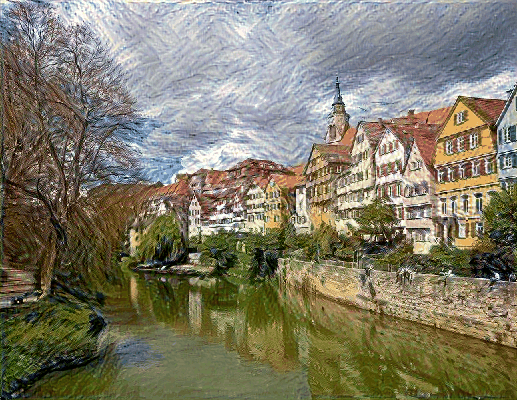

In [3]:
b64 = base64.b64encode(open('./output/gif/gif_test_1_10.gif','rb').read()).decode('ascii')
display(HTML(f'<img src="data:image/gif;base64,{b64}" />'))

# 8) Generar imágenes para distintas combinaciones de pesos de las losses. Explicar las diferencias. (Adjuntar las imágenes generadas como archivos separados.)

#### Respuesta: <br />
- En el primer experimento se varió el __style_weight__ de a un orden de magnitud de __10, 100, 1000 y 10000__. En los 4 ajustes se hicieron __100 iteraciones__. Se dejó fijo el __content_weight__ en 1 y el __total_variation_weight__ se lo dejó como el ratio __content_weight/style_weight__. Se observan los resultados en el siguiente GIF compuesto por las 4 imágenes de la iteración 100 en el orden mencionado.<br />
Podemos observar como a medida que aumenta el __style_weight__ queda más marcado el estilo elegido, a expensas de perder contenido. Esto se observa en los detalles que se van perdiendo de los edificios y se va plasmando la huella del estilo.


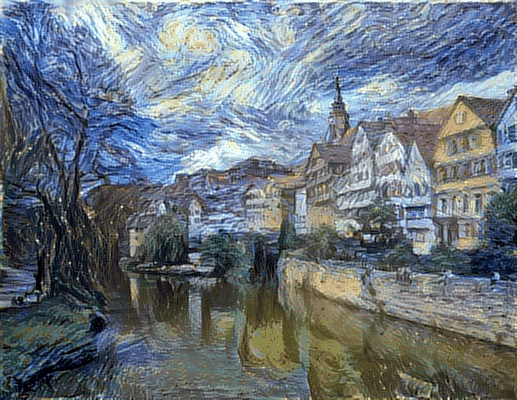

In [9]:
b64 = base64.b64encode(open('./output/gif/gif_testing.gif','rb').read()).decode('ascii')
display(HTML(f'<img src="data:image/gif;base64,{b64}" />'))

- En el segundo experimento se le dió un peso de __10 al contenido__ y un peso de __1 al estilo__, es decir un __ratio inverso__ al anterior, y el __total_variation_weight quedó en 10__. Se puede observar en la imagen correspondiente a la iteración 100, como se mantuvo el contenido y como se suavizo la imagen, esto es por los pesos que se le dieron a los distintos términos de la función de costo. En especial se puede observar como el término del total variation ponderó la continuidad lateral, esto se observa en el trazo del cielo.

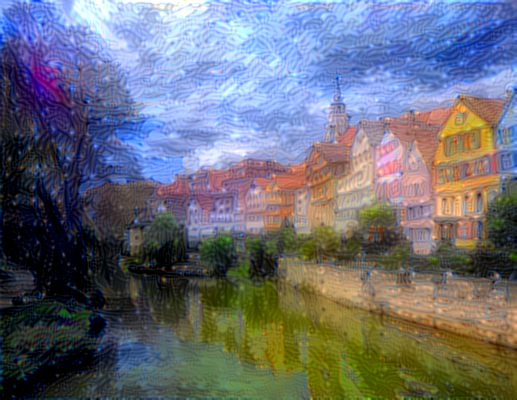

In [8]:
img = load_img('./output/test_10_1/output_at_iteration_99.png')
img


# 9) Cambiar las imágenes de contenido y estilo por unas elegidas por usted. Adjuntar el resultado.

##### Respuesta: <br />

- Como imagen de contenido elegí una foto de mi oficina, en el Departamento de Geofísica Aplicada en la Facultad de Ciencias Astronómicas y Geofísicas de la Universidad Nacional de La Plata.
- Como imagen de estilo elegí la pintura el grito de Edvard Munch.
- Corrí el ajuste con los siguientes parámetros:<br />
    - __total_variation_weight__ = 10 <br />
    - __style_weight__ = 10000 <br />
    - __content_weight__ = 1
    - __iterations__ = 100

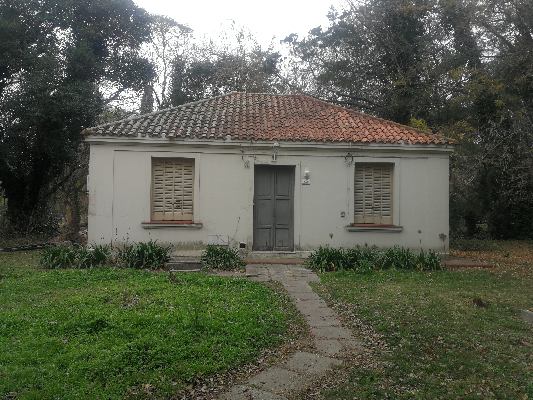

In [2]:
img = load_img('./images/oficina.png')
img

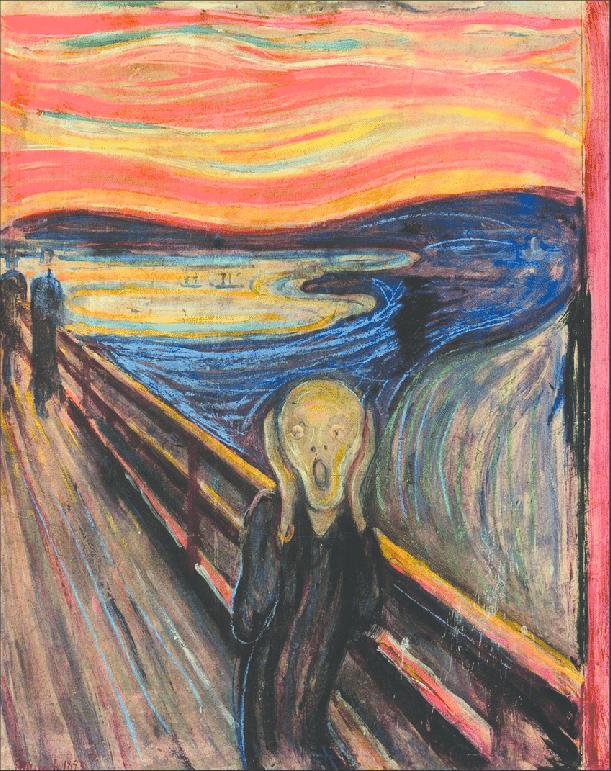

In [11]:
img = load_img('./images/el_grito.png')
img

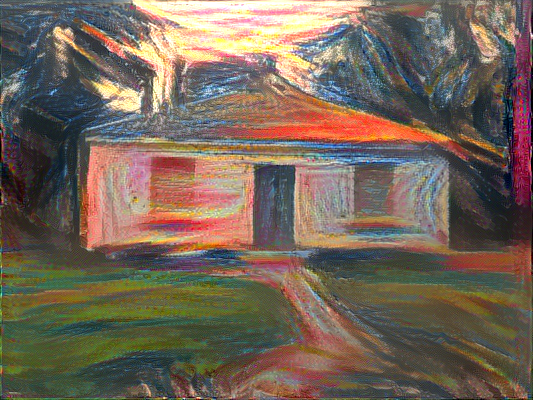

In [14]:
img = load_img('./output/grito_ofi_1_10000_10/output_at_iteration_99.png')
img